### Set up 
***

#### Notebook settings

In [ ]:
import os 
os.getcwd()

In [ ]:
os.chdir('../')
os.getcwd()

#### Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from production_code import constants

In [4]:
db = pd.read_excel('data/db_us_equity.xlsx')
db.sort_values(by='Date', ascending=True, inplace=True)
db.set_index('Date', inplace=True)
db = db.loc[(db.index <= constants.NON_POW_END_DATE) & (db.index >= constants.NON_POW_START_DATE)]

In [5]:
db.head()

,PX_LAST,PX_VOLUME
Date,,
2007-01-03,105.9943,215662
2007-01-04,106.0413,171227
2007-01-05,104.1851,206596
2007-01-08,103.9267,221408
2007-01-09,103.9032,162289


In [6]:
db.tail()

,PX_LAST,PX_VOLUME
Date,,
2009-06-24,46.1287,1673465
2009-06-25,47.9848,1905159
2009-06-26,48.3373,1190272
2009-06-29,49.0421,914565
2009-06-30,47.7734,1283022


In [7]:
db["LOG_RETURNS"] = np.log(db["PX_LAST"]) - np.log(db["PX_LAST"].shift(-1))

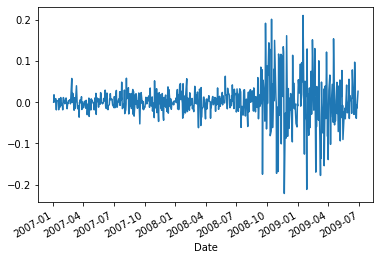

In [8]:
db["LOG_RETURNS"].plot()

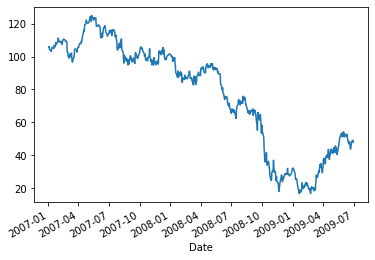

In [9]:
db["PX_LAST"].plot()

### Haar wavelet implementation
***

In [10]:
def firstHalfIndicator(t: float) -> int:
    return ((0 <= t) and (t < 0.5)) * 1

def secondHalfIndicator(t):
    return ((0.5 <= t) and (t < 1)) * 1

def haarMother(t: float) -> int:
    return firstHalfIndicator(t) - secondHalfIndicator(t)

vhaarMother = np.vectorize(haarMother)

In [11]:
x = np.linspace(-2, 2, 100)
y = vhaarMother(x)

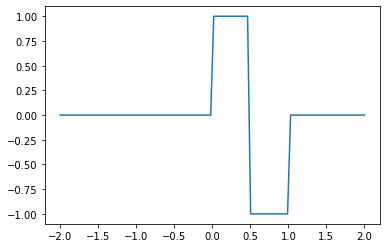

In [12]:
plt.plot(x,y)

In [13]:
def haarWaveletFunction(j: float, k: float, t: float) -> float:
    return pow(2, j / 2) * haarMother(pow(2, j) * t - k)

vhaarWaveletFunction = np.vectorize(haarWaveletFunction)

In [14]:
y1 = vhaarWaveletFunction(0, 0, x)

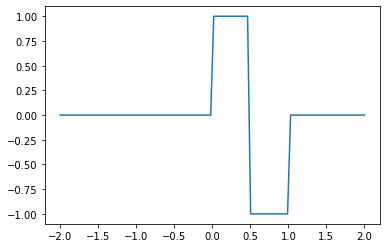

In [15]:
plt.plot(x, y1)

<b>Parameter influence for different wavelet functions</b>

##### Translation parameter

In [16]:
results = [vhaarWaveletFunction(0, j, x) for j in range(-2, 2)]

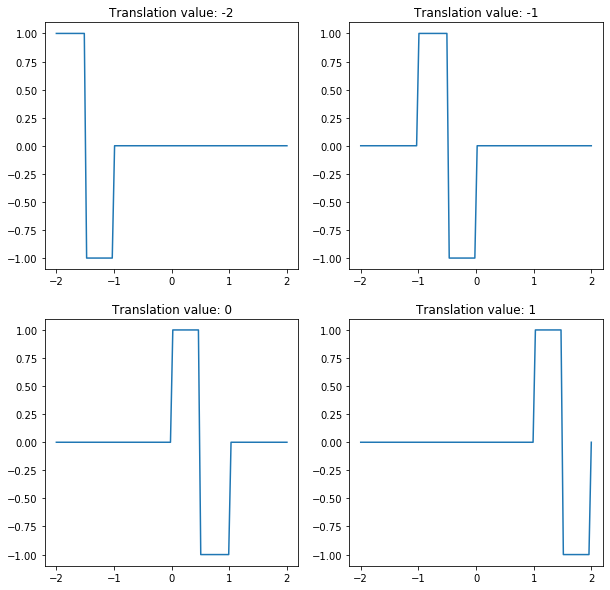

In [17]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Translation value: {i - 2}")
    ax.plot(x, results[i])

#### Resolution parameter

In [18]:
results = [vhaarWaveletFunction(j, 0, x) for j in range(0, 4)]

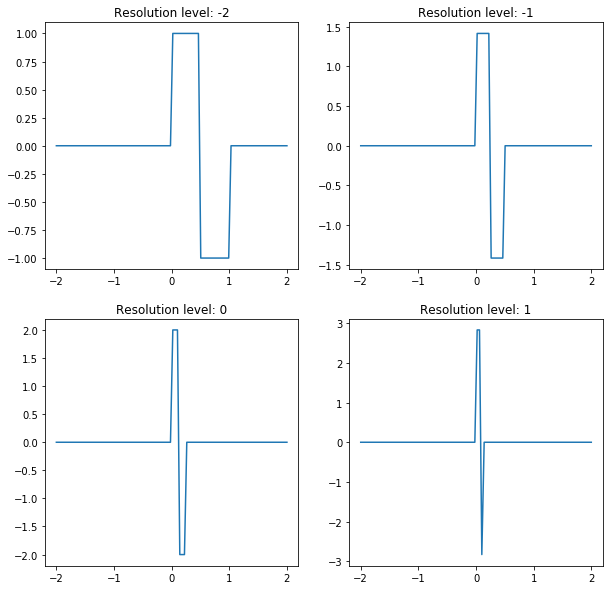

In [19]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Resolution level: {i - 2}")
    ax.plot(x, results[i])

In [20]:
results = [vhaarWaveletFunction(-j, 0, x) for j in np.arange(0.0, 4.0)]

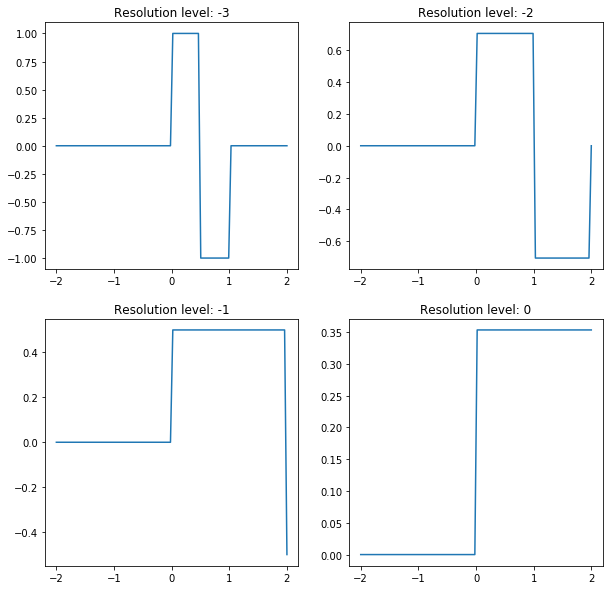

In [21]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Resolution level: {i - 3}")
    ax.plot(x, results[i])

### Define signal for study
***

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from production_code import constants

In [23]:
signal = pd.read_excel('data/eurusd.xlsx').sort_values(by='Date').set_index('Date')
signal = signal.loc[(signal.index <= constants.NON_POW_END_DATE) & (signal.index >= constants.NON_POW_START_DATE)]

In [24]:
signal.head()

,PX_LAST
Date,
2007-01-01,1.3201
2007-01-02,1.3273
2007-01-03,1.3169
2007-01-04,1.3084
2007-01-05,1.3002


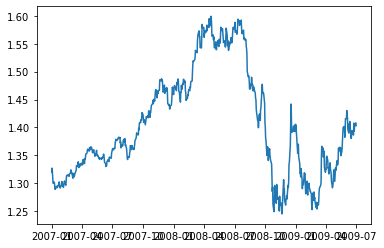

In [25]:
plt.plot(signal)

In [26]:
signal = signal["PX_LAST"].to_numpy()

### @Yannis Excel translation
***

In [27]:
# Parameters
j = -4
t = np.linspace(0, len(signal)-1, len(signal))
k =  np.linspace(-1, len(signal)-2, len(signal))

Text(0.5, 1.0, 'k, size=652')

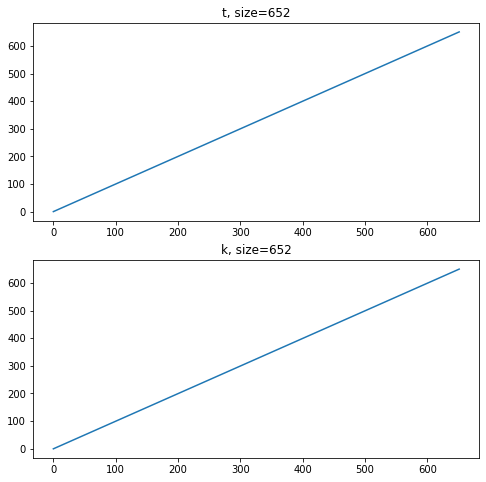

In [28]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(t)
ax[0].set_title(f't, size={len(t)}')
ax[1].plot(k)
ax[1].set_title(f'k, size={len(k)}')

In [29]:
# Shift step
nb_k = int(np.ceil(len(signal) / pow(2, -j)) + 2)

In [30]:
# Initialize results
k1 = np.array(np.zeros(nb_k+1))
k2 = np.array(np.zeros(nb_k+1))
coeff = np.array(np.zeros(nb_k+1))

In [31]:
# Scale coefficient
for i in range(0, nb_k+1):
    k1[i] = k[i] * 2**(-j)
    k2[i] = (k[i] + 1) * 2**(-j)
    
    sum1 = 0
    sum2 = 0

    for p in range(0, len(signal)):
        if(t[p] >= k1[i]):
            sum1 += signal[p]
        if(t[p] >= k2[i]):
            sum2 += signal[p]

    coeff[i] = 2**(j/2) * (sum1 - sum2)

In [32]:
# Initialisations
t1 = np.array(np.zeros(len(signal)-1))
t2 = np.array(np.zeros(len(signal)-1))
approx = np.array(np.zeros(len(signal)))

In [33]:
# Approximation
for i in range(1, len(signal)):
    t1[i-1] = 2**j * t[i-1] - 1
    t2[i-1] = 2**j * t[i-1]
    
    sum1 = 0
    sum2 = 0
    for p in range(0, nb_k):
        if(k[p] >= t1[i-1]):
            sum1 += coeff[p]
        if(k[p] >= t2[i-1]):
            sum2 += coeff[p]
        
    approx[i] = 2**(j/2) * (sum1 - sum2)

In [34]:
coeff = coeff[1:np.size(coeff)-3]    
approx = approx[2:len(signal)-2**(-j)]

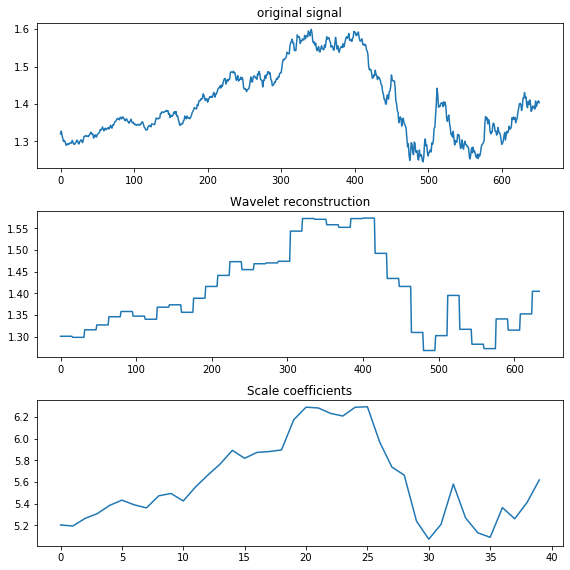

In [35]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(signal)
ax[0].set_title("original signal")
ax[1].plot(approx)
ax[1].set_title("Wavelet reconstruction")
ax[2].plot(coeff)
ax[2].set_title("Scale coefficients")
fig.tight_layout(pad=1)

### Simulate signal

In [36]:
sinusSignal = np.sin(np.linspace(-np.pi, np.pi, 100))

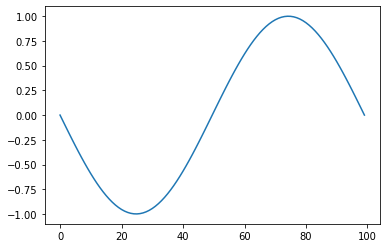

In [37]:
plt.plot(sinusSignal)

### @Francisco implementation

In [38]:
j = -4

In [39]:
'''prelim_results = list()
for k in range(1, 13):
    zjk = list()
    for t, sig in enumerate(sinusSignal):
        zjk.append(sig * haarWaveletFunction(j, k, t))
    prelim_results.append(zjk)'''

'prelim_results = list()\nfor k in range(1, 13):\n    zjk = list()\n    for t, sig in enumerate(sinusSignal):\n        zjk.append(sig * haarWaveletFunction(j, k, t))\n    prelim_results.append(zjk)'

In [40]:
'''fig, ax = plt.subplots(6,2,figsize=(16,16))
for i, ax in enumerate(fig.axes):
    ax.plot(prelim_results[i])
    ax.set_title(f'translation value {i}')
fig.tight_layout(pad=1)'''

"fig, ax = plt.subplots(6,2,figsize=(16,16))\nfor i, ax in enumerate(fig.axes):\n    ax.plot(prelim_results[i])\n    ax.set_title(f'translation value {i}')\nfig.tight_layout(pad=1)"

<b>Implementation</b>
<p>We know from the wavelet function equations derived from the mother Haar wavelet that the support for a wavelet function $\psi_{j, k}(t)$ is $t \notin [2^{-j}k, 2^{-j}(k+1)[$ therefore we only need to compute the function at those points.</p>

1) Given that the step size is $k * 2^{-j}$ ([see slide 16](http://people.ciirc.cvut.cz/~hlavac/TeachPresEn/11ImageProc/14WaveletsEn.pdf)) figure out how many steps we can make for a given j

In [41]:
t_arr = np.arange(1.0, len(signal) + 1)
nrows = len(t_arr)
stepSize = pow(2, abs(j)) #ensure j is positive
maxSteps = int(nrows / stepSize)

In [42]:
maxSteps

40

2) Compute the wavelet coefficients for the given resolution level j

In [43]:
import math

zjk = list()
for k in range(1, maxSteps + 1):
    # Get wavelet function support
    first = math.floor(pow(2, -j) * k)
    second = math.ceil(pow(2, -j) * (k + 1))
    # Compute the local decomposition
    waveletCoeff = 0
    for t, sig in enumerate(signal[first:second]):
        waveletCoeff += sig * haarWaveletFunction(j, k, t + first)
    zjk.append(waveletCoeff)

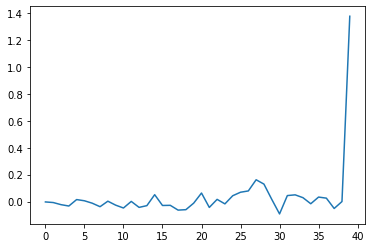

In [44]:
plt.plot(zjk)

3) Recompose

<p>Reconstructed signal for a given resolution level j is called the the detail signal</p>

In [45]:
j

-4

In [46]:
detailSignal = list()
for t in t_arr:
    sig = 0
    for k in range(0, maxSteps):
        first = math.floor(pow(2, -j) * k)
        second = math.ceil(pow(2, -j) * (k + 1))
        if t <= first:
            continue
        if t > second:
            continue
        sig += zjk[k] * haarWaveletFunction(j, k, t)
    detailSignal.append(sig)

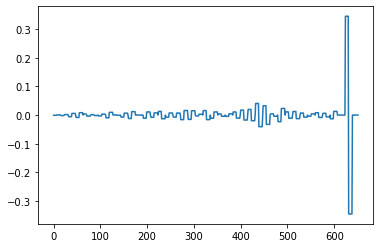

In [47]:
plt.plot(detailSignal)

<b>Do the same for multiple Js</b>

In [48]:
allJs = [j for j in range(11)]

In [49]:
allJs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [50]:
# every element of WT is a decomposition for a given j
WT = dict() 

Decompose at different resolution levels

In [51]:
for j in allJs:
    zjk = list()
    for k in range(1, maxSteps + 1):
        # Get wavelet function support
        first = math.floor(pow(2, -j) * k)
        second = math.ceil(pow(2, -j) * (k + 1))
        # Compute the local decomposition
        waveletCoeff = 0
        for t, sig in enumerate(signal[first:second]):
            waveletCoeff += sig * haarWaveletFunction(j, k, t + first)
        zjk.append(waveletCoeff)
    WT[j] = zjk

Compute the detail signals at every resolution level j

In [52]:
# Every element is the detail signal at resolution level j
invWT = dict()

In [53]:
for j in allJs:
    detailSignalJ = list()
    for t in t_arr:
        sig = 0
        for k in range(0, maxSteps):
            first = math.floor(pow(2, -j) * k)
            second = math.ceil(pow(2, -j) * (k + 1))
            if t <= first:
                continue
            if t > second:
                continue
            sig += zjk[k] * haarWaveletFunction(j, k, t)
        detailSignalJ.append(sig)
    invWT[j] = detailSignalJ

In [54]:
# Compute entire signal
reconstructedSignal = np.zeros(len(invWT[0]))
for j in invWT.keys():
    reconstructedSignal += np.array(invWT[j])

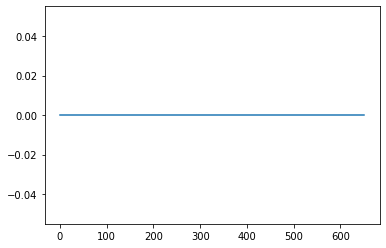

In [55]:
plt.plot(reconstructedSignal)